In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sql_connection import sql_connect, write_sql_conn_create
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.decomposition import PCA
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import warnings
warnings.filterwarnings("ignore", message="pandas only supports SQLAlchemy connectable")

In [22]:
query = "select * from cleaned_application_ml"
app_data = sql_connect(query)
app_data.head()

Connection to SQL Server established successfully.
Connection closed.


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AVERAGE_EXTERNAL_RATING,TOT_PREV_APP,PREV_APPROVED_CNT,PREV_CANCELLED_CNT,PREV_REFUSED_CNT,PREV_UNUSED_CNT,ISMISSING_BUREAU_INFO
0,100002,1,Cash loans,M,0,1,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120.0,-1,1,1,0,1,1,0,Laborers,1,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,2,2,2,2,-1134,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.1618,0,0,0,0,0,0
1,100003,0,Cash loans,F,0,0,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291.0,-1,1,1,0,1,1,0,Core staff,2,1,1,MONDAY,11,0,0,0,0,0,0,School,1,0,1,0,-828,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.4668,0,0,0,0,0,0
2,100004,0,Revolving loans,M,1,1,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531.0,26,1,1,1,1,1,0,Laborers,1,2,2,MONDAY,9,0,0,0,0,0,0,Government,0,0,0,0,-815,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.6427,0,0,0,0,0,0
3,100006,0,Cash loans,F,0,1,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437.0,-1,1,1,0,1,0,0,Laborers,2,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,2,0,2,0,-617,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.6504,0,0,0,0,0,1
4,100007,0,Cash loans,M,0,1,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458.0,-1,1,1,0,1,0,0,Core staff,1,2,2,THURSDAY,11,0,0,0,0,1,1,Religion,0,0,0,0,-1106,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.3227,1,1,0,0,0,0


Numeric field will need to be standardized before apply pca

In [ ]:
numeric_col = [col for col in app_data.columns if app_data[col].dtype != 'object' and app_data[col].nunique() > 2 and col not in ['SK_ID_CURR', 'TARGET']]

### Class imbalance

Text(0.5, 0, 'Target')

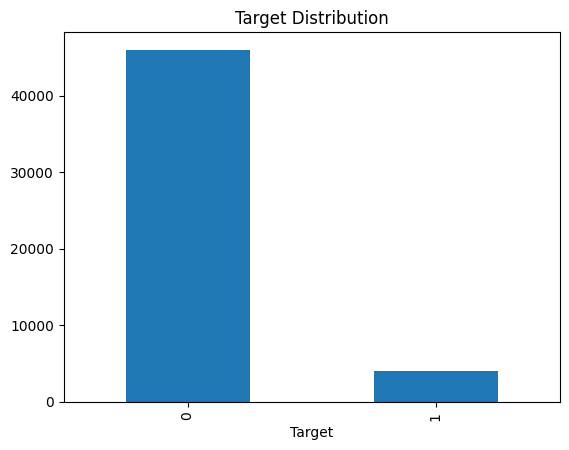

In [25]:
app_data['TARGET'].value_counts().plot(kind='bar', title='Target Distribution')
plt.xlabel('Target')    

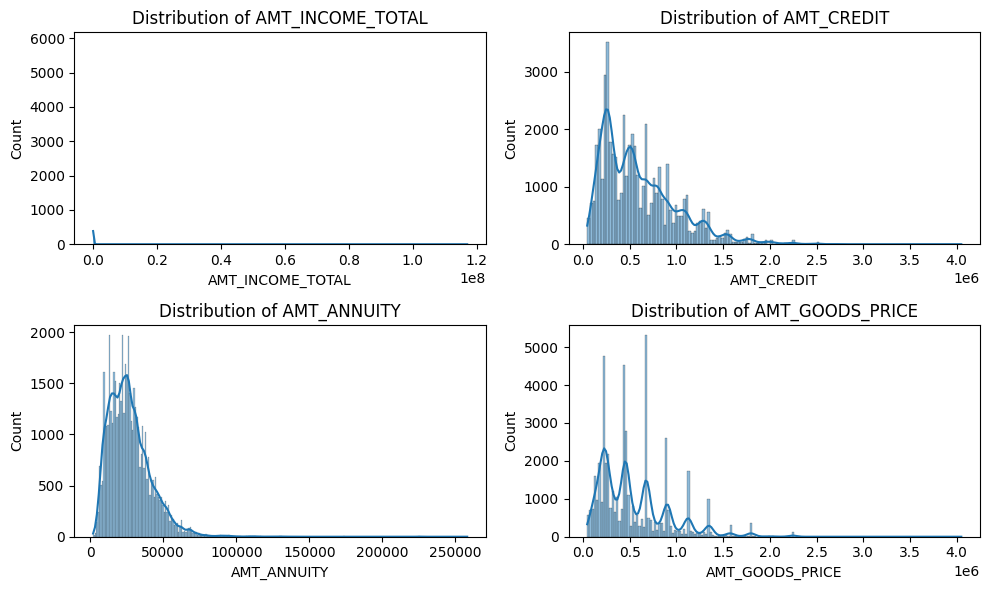

In [26]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6))
ax = ax.flatten()
for i, col in enumerate(numeric_col[1:5]):
    sns.histplot(app_data[col], kde=True, ax=ax[i])
    ax[i].set_title(f'Distribution of {col}')
plt.tight_layout()
plt.show();

### All the amount data are highly skewed

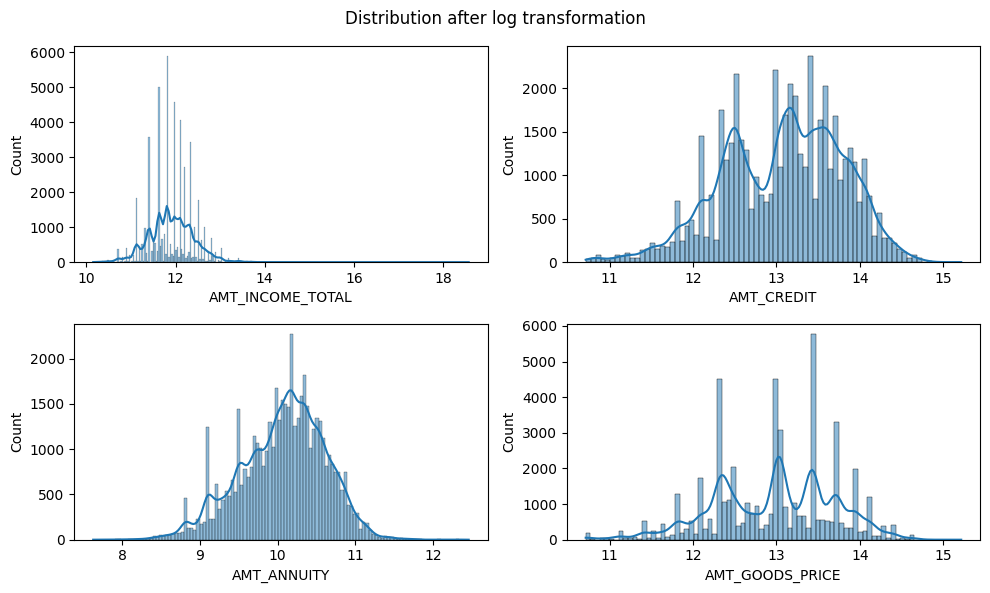

In [27]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6))
ax = ax.flatten()
for i, col in enumerate(numeric_col[1:5]):
    sns.histplot(np.log1p(app_data[col]), kde=True, ax=ax[i])
plt.suptitle(f'Distribution after log transformation')
plt.tight_layout()
plt.show();

In [28]:
for col in numeric_col[1:5]:
    app_data[col] = np.log1p(app_data[col])



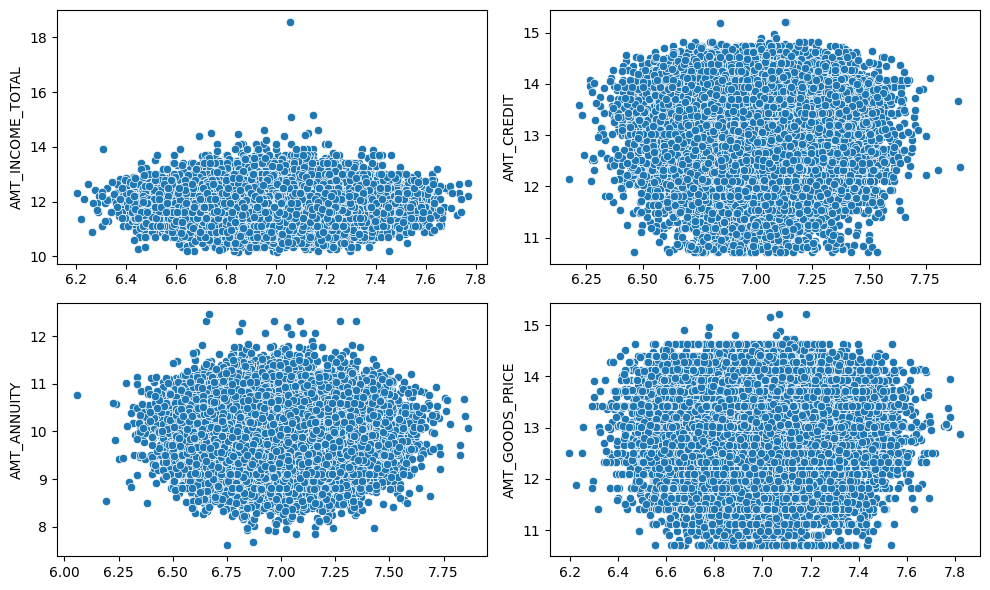

In [29]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6))
ax = ax.flatten()
for i, col in enumerate(numeric_col[1:5]):
   
    sns.scatterplot(x=np.random.normal(7, 0.2, size=len(app_data)), y=app_data[col], ax=ax[i])
plt.tight_layout()
plt.show()

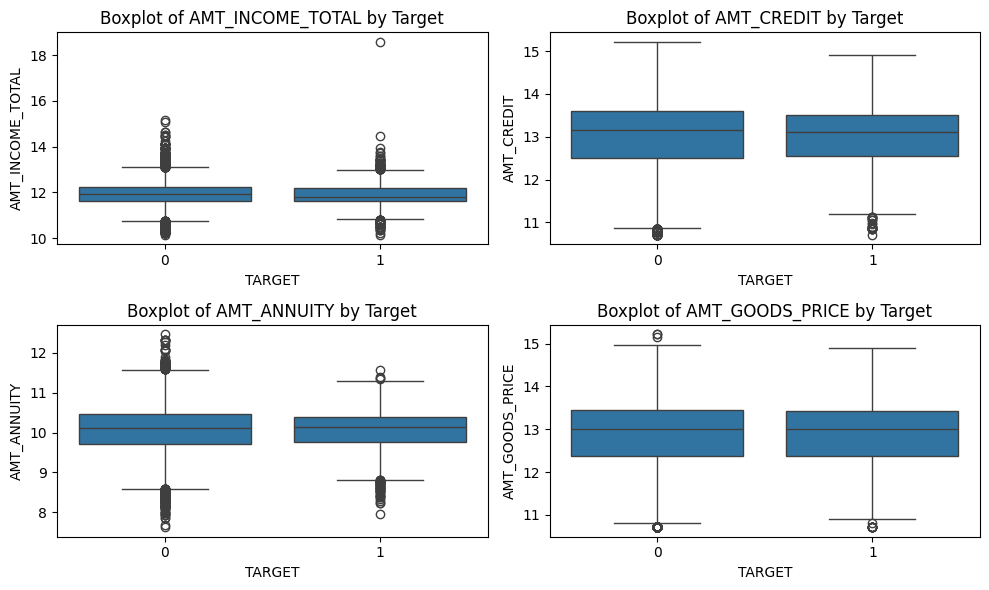

In [30]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6))
ax = ax.flatten()
for i, col in enumerate(numeric_col[1:5]):
    #column = col  + '_LOG'
    sns.boxplot(x = 'TARGET', y = col, ax=ax[i], data=app_data)
    ax[i].set_title(f'Boxplot of {col} by Target')
plt.tight_layout()
plt.show();

### iT DOESNT LOOK LIKE REPAUYMENT DIFFICULTIES DEPEND ON THESE IMPORTANT COLUMN
The hwat could it be  
There are alot of column here visualizing each will be an issue

We need to dimenstionality reduction to plot 

Lets go with PCA,

need to standardized the data

In [54]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


X = app_data.drop(columns=['SK_ID_CURR', 'TARGET'])
y = app_data['TARGET']

numeric_cols = [col for col in X.columns if X[col].dtype != 'object' and X[col].nunique() > 2]
binary_cols = [col for col in X.columns if X[col].dtype != 'object' and X[col].nunique() == 2]
categorical_cols = [col for col in X.columns if X[col].dtype == 'object']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols),
        ('bin', 'passthrough', binary_cols)
    ]
)

X_transformed = preprocessor.fit_transform(X)



In [ ]:
from sklearn.decomposition import  PCA

pca_model = PCA()

pca_x = pca_model.fit_transform(X_transformed)


In [109]:
loadings = pd.DataFrame(
    pca_model.components_.T,             # shape: (features, PCs)
    index=X.columns,                     # original feature names
    columns=[f'PC{i+1}' for i in range(pca_model.n_components_)]
)


ValueError: Shape of passed values is (182, 182), indices imply (77, 182)

In [101]:
cum_var = np.cumsum(pca_model.explained_variance_ratio_)
cum_var

array([0.09094572, 0.16936417, 0.23397735, 0.29355343, 0.34837599,
       0.39149058, 0.42693022, 0.46157342, 0.49246246, 0.5216971 ,
       0.54986735, 0.57563991, 0.6013095 , 0.62663421, 0.65147899,
       0.6755639 , 0.69841777, 0.72123375, 0.74276781, 0.76315721,
       0.78223457, 0.79943246, 0.81637221, 0.83125502, 0.8425507 ,
       0.85134325, 0.85957236, 0.86712249, 0.87429135, 0.88075635,
       0.88688601, 0.8927709 , 0.89830322, 0.90364245, 0.9083666 ,
       0.91281378, 0.91723167, 0.92153832, 0.9257668 , 0.92940771,
       0.93301404, 0.93647592, 0.93952174, 0.94252929, 0.9453743 ,
       0.94816183, 0.95063545, 0.95299606, 0.95527028, 0.95739576,
       0.9593584 , 0.96126046, 0.96311251, 0.9649241 , 0.96665861,
       0.96822618, 0.96970734, 0.9711465 , 0.97253787, 0.97388268,
       0.97519051, 0.97646636, 0.97771066, 0.97892854, 0.98007271,
       0.98112708, 0.98216879, 0.98319203, 0.98404329, 0.98482504,
       0.98555524, 0.98620966, 0.98677335, 0.98732985, 0.98786

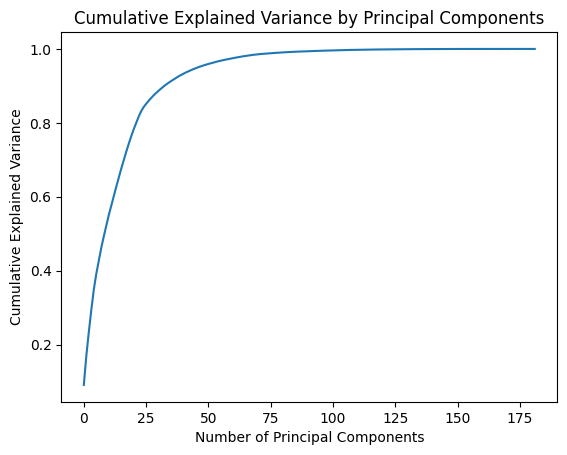

In [70]:
plt.plot(cum_var)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Principal Components');

In [78]:
len(cum_var[cum_var < 0.95])

46

### Key Insights
1. Data is able to explained by 46 princple coponent, this will be useful while modelling
2. Still we cant visualize the pattern between two classes, we need to use different techniques

pca_x[:, :4]

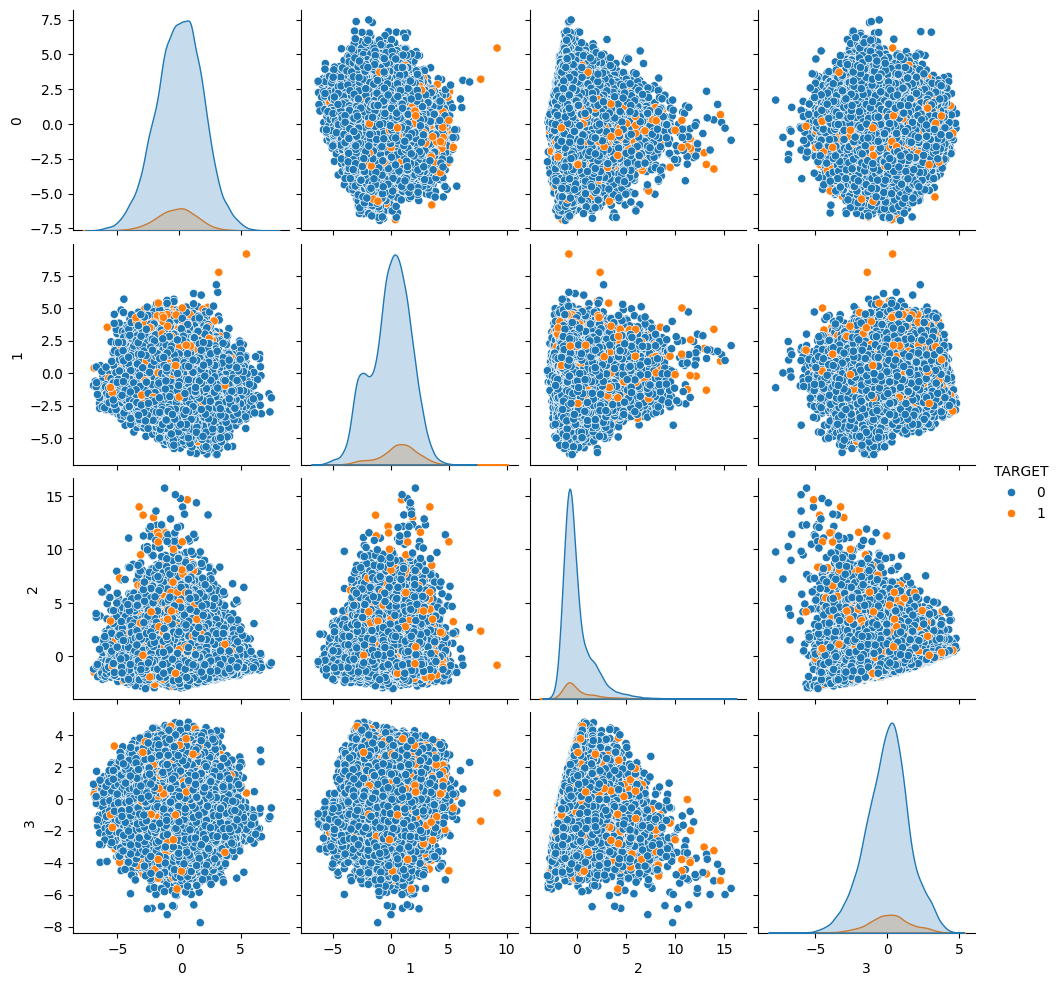

In [100]:
pca_df = pd.DataFrame(pca_x[:, :4]) 
pca_df['TARGET'] = y.values  


sns.pairplot(pca_df, hue='TARGET')

### No clear seperation

The dataset contains a high number of features (181 columns), many of which are numeric, categorical, or binary. While basic univariate distributions and correlation heatmaps were explored, meaningful patterns between the features and the target variable (TARGET) were not visually obvious.

Even after applying dimensionality reduction techniques like PCA (Principal Component Analysis) and visualizing the first few principal components, there was no clear separation between classes. This is expected in high-dimensional tabular data, where complex patterns may not be easily captured or visualized in 2D.

Therefore, further exploration via traditional EDA is unlikely to yield actionable insights. We now proceed to modeling, where machine learning algorithms can leverage the full feature space to uncover predictive patterns.